# A Bayesian model of book sales and literary prestige

Historians often have to work with missing evidence. 

Book sales figures, for instance, are notoriously patchy. If we're interested in comparing a few famous authors, we can do pretty well. That legwork has been done. But if we want to construct a "sales estimate" for every single name in a library containing thousands of authors — good luck! You would have to dig around in publishers' archives for decades, and you still might not find evidence for half the names on your list. Not everything has been preserved.

And yet, in reality, we can of course make pretty decent guesses. We may not know exactly how many volumes they sold, but we can safely wager that [Willa Cather](https://catalog.hathitrust.org/Search/Home?lookfor=%22Cather,%20Willa,%201873-1947.%22&type=author&inst=) was more widely read in her era than [Wirt Sikes](https://catalog.hathitrust.org/Search/Home?lookfor=%22Sikes%2C%20Wirt%22&searchtype=author&ft=&setft=false) was in his.

Well, that guesswork is real reasoning, and a Bayesian theory of knowledge would allow us to explain it in a principled way. That's my goal in this notebook. I'm going to use an approach called "empirical Bayes" to estimate the relative market prominence of fiction writers between 1850 and 1950, treating the US and UK as parts of a single market. The strategy I adopt is based on leveraging two sources of evidence that loosely correlate with each other:

**1) Bestseller lists, whether provided by *Publisher's Weekly* or assembled less formally by book historians.**

**2) The number of books by each author preserved in US university libraries, plus some evidence about publication in pulp magazines.**

Neither of these sources is complete; neither is perfectly accurate. But we're going to combine them in a way that will allow each source to compensate for the errors and omissions in the other.

If we had unlimited time and energy, we could gather lots of additional sources of evidence: library circulation records, individual publishers' balance sheets, and so on. But time is limited, and I just want a rough estimate of authors' relative market prominence. So we'll keep this quick and dirty.

#### Acknowledgments

This notebook is a tiny lantern placed on top of a tower built by many other hands.

The idea for this approach was drawn from [Julia Silge's post on empirical Bayes in song lyrics,](http://juliasilge.com/blog/Bayesian-Blues/) which in turn drew on [blog posts by David Robinson.](http://varianceexplained.org/r/empirical_bayes_baseball/) Evidence about nineteenth-century bestsellers was extracted from Altick 1957, Mott 1947, Leavis 1935, and Hackett 1977, and drawn up in tabular form by Jordan Sellers. Jordan Sellers also created a sample of stories in pulp magazines between 1897 and 1939. Lists of twentieth-century bestsellers were transcribed by John Unsworth, and scraped into tabular form by Kyle R. Johnston ([see his post on modeling the texts of bestsellers](http://kylerjohnston.com/posts/what-makes-a-bestseller/)). 

At the bottom of the notebook, when we start talking about critical prestige, I'll draw on information about reviews collected by Sabrina Lee and Jessica Mercado.

#### References

Altick, Richard D. *The English Common Reader:  A Social History of the Mass Reading Public 1800-1900.* Chicago: University of Chicago Press, 1957.

Bloom, Clive. *Bestsellers: Popular Fiction Since 1900.* 2nd edition. Houndmills: Palgrave Macmillan, 2008.

Hackett, Alice Payne, and James Henry Burke. *80 Years of Best Sellers 1895-1975.*
New York: R.R. Bowker, 1977.

Leavis, Q. D. *Fiction and the Reading Public.* 1935.

Mott, Frank Luther. *Golden Multitudes: The Story of Bestsellers in the United States.* New York: R. R. Bowker, 1947.

Unsworth, John. *20th Century American Bestsellers.* (http://bestsellers.lib.virginia.edu)

In [322]:
# BASIC IMPORTS BEFORE WE BEGIN
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import csv
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import numpy as np
import random
import scipy.stats as ss

## Bestseller lists

Basically, my strategy here is simply to count *the number of times an author was mentioned on a bestseller list between 1850 and 1949*. A book that appears on two different lists will count twice. This strategy will reward authors for being prolific more than it rewards them for writing a single mega-blockbuster, but that's exactly what I want to do — I'm interested in authorial market share here, not in individual books.

This data relies on underlying reports from Mott and *Publisher's Weekly,* who emphasize sales in the United States, as well as Altick, Hackett, and Bloom, who pay more attention to Britain. Bloom considers the pulp market more than most previous lists had done. In short, the lists overlap a lot, but also diverge. When they're aggregated, many authors will be mentioned once or twice, while prolific authors who are the subjects of strong consensus may be mentioned ten or twelve times.

Overall, coverage of the period after 1895 is much better than it is as we go back into the nineteenth century, so we should expect authors in the earlier period both to be

    1) undercounted, and

    2) counted less reliably overall.

Also, authors near either end of the timeline may be undercounted, because their careers will extend beyond the end points.

The actual counting is done in [a "child" notebook;](https://github.com/tedunderwood/bayes-bestsellers/blob/master/count_bestseller_lists.ipynb) here we just import the results it produced. The most important column is **salesevidence,** which aggregates the counts from US-focused and UK-focused sources.

In [434]:
list_occurrences = pd.read_csv('counted_bestsellers.csv', index_col = 'author')
# that combines Altick, Hackett, Leavis, Mott, Publishers Weekly
list_occurrences = list_occurrences.sort_values(by = 'salesevidence', ascending = False)  
list_occurrences.head()

,is_other,is_uk,is_us,nationality,reviews,uklist,uslists,salesevidence
author,,,,,,,,
"Dickens, Charles",0.0,1.0,0.0,uk,4.0,10.0,7.0,17.0
"Wood, Ellen",0.0,1.0,0.0,uk,0.0,16.0,1.0,17.0
"(Lloyd Cassel), Douglas, Lloyd C",0.0,0.0,1.0,us,0.0,2.0,12.0,14.0
"Churchill, Winston",0.0,0.0,1.0,us,1.0,0.0,13.0,13.0
"Ward, Mary Augusta",0.0,1.0,0.0,uk,2.0,9.0,4.0,13.0


In [435]:
print("The whole data frame has " + str(list_occurrences.shape[0]) + " rows.")
nonzero = sum(list_occurrences.salesevidence > 0)
print("But only " + str(nonzero) + " authors have nonzero occurrences in the bestseller lists.")

The whole data frame has 1177 rows.
But only 378 authors have nonzero occurrences in the bestseller lists.


That's a nice list, but it only covers 378 out of 1177 authors — a relatively small slice at the top of the market. Many of the differences that might interest us are located further down the spectrum of prestige. But those differences are invisible in bestseller lists. So we need to enrich them with a second source.

## Works preserved in libraries and other bibliographic records

One crude way to assess an author's prominence during their lifetime is to ask how many of their books got bought and preserved.

Please note the word "crude." Book historians have spent a lot of energy demonstrating that the sample of volumes preserved in a university library *is not the same thing as* the broader field of literary circulation. And of course they're right.

But we're not looking for an infallible measure of sales here — just a proxy that will loosely correlate with popularity, allowing us to flesh out some of the small differences at the bottom of the market that are elided in a "bestseller list." We're not going to use this evidence to definitively settle the kind of long-running dispute book historians may have in mind. ("Was Agatha Christie really more popular than Wilkie Collins?") We're going to use it to make a rough guess that [Wirt Sikes](https://catalog.hathitrust.org/Record/009245338?type%5B%5D=author&lookfor%5B%5D=%22Sikes%2C%20Wirt%2C%201836-1883.%22&ft=) was less popular than either Christie or Collins, and probably less popular for that matter than lots of other semi-obscure names.

The code that does the actual counting is complex and messy, because we have to worry about pseudonyms, initials, and so on. So I've placed all that in a "child" notebook, and just imported the results here. Suffice it to say that we estimate a "midcareer" year for each author, and then count volumes of fiction in HathiTrust published thirty years before or after that date (but not outside 1835 or 1965). I also count references to publication in pulp magazines drawn from a dataset organized by Jordan Sellers; this doesn't completely compensate for the underrepresentation of the pulps in university libraries, but it's a gesture in that direction.

In [436]:
career_volumes = pd.read_csv('career_volumes.csv')
career_volumes.set_index('author', inplace = True)
career_volumes.head()

,raw_num_vols,midcareer
author,,
"Mallock, W. H",43,1895
"Wood, H. F",2,1890
"Owen, Octavius Freire",3,1859
"Mitchell, S. Weir",152,1898
"Ford, Paul Leicester",47,1897


#### correcting for temporal biases

The number of volumes preserved can depend on a lot of historical accidents. It varies over time in a way that will need correction. As you can see below, there's a bias toward the middle of the timeline. By measuring the bias, we can adjust for it.

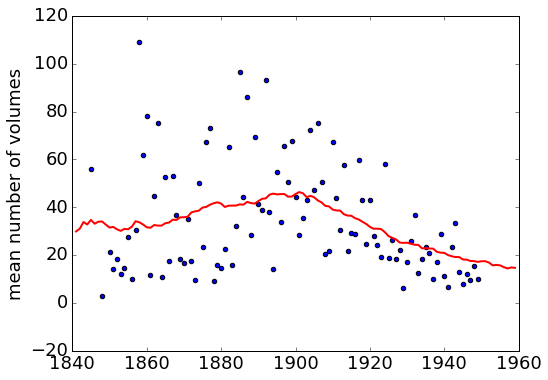

In [437]:
# Let's explore historical variation.

years = []
meanvols = []
movingwindow = []
for i in range (1841, 1960):
    years.append(i)
    meanvols.append(np.mean(career_volumes.raw_num_vols[career_volumes.midcareer == i]))
    window = np.mean(career_volumes.raw_num_vols[(career_volumes.midcareer >= i - 20) & (career_volumes.midcareer < i + 21)])
    movingwindow.append(window)

fig, ax = plt.subplots(figsize = (8, 6))
ax.scatter(years, meanvols)
ax.plot(years, movingwindow, color = 'red', linewidth = 2)
ax.set_xlim((1840,1960))
ax.set_ylabel('mean number of volumes')
plt.show()

In [438]:
# Let's calculate the necessary adjustment factor.

historical_adjuster = np.mean(movingwindow) / np.array(movingwindow)
dfdict = {'year': years, 'adjustmentfactor': historical_adjuster}
adjustframe = pd.DataFrame(dfdict)
adjustframe.set_index('year', inplace = True)
adjustframe.head()

,adjustmentfactor
year,
1841,1.085331
1842,1.045679
1843,0.958745
1844,0.989097
1845,0.934572


Now we can multiply each author's raw number of volumes by the adjustment factor for that year. Not elegant, not perfect, but it gets rid of the biggest distortions.

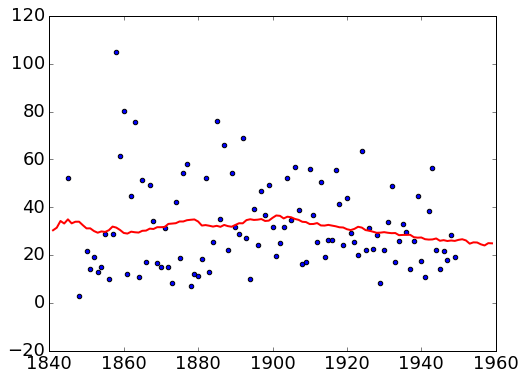

In [439]:
career_volumes['num_vols'] = 0
for author in career_volumes.index:
    midcareer = career_volumes.loc[author, 'midcareer']
    rawvols = career_volumes.loc[author, 'raw_num_vols']
    adjustment = adjustframe.loc[midcareer, 'adjustmentfactor']
    career_volumes.loc[author, 'num_vols'] = int(rawvols * adjustment * 100) / 100
career_volumes.head()

years = []
meanvols = []
movingwindow = []
for i in range (1841, 1960):
    years.append(i)
    meanvols.append(np.mean(career_volumes.num_vols[career_volumes.midcareer == i]))
    window = np.mean(career_volumes.num_vols[(career_volumes.midcareer >= i - 20) & (career_volumes.midcareer < i + 21)])
    movingwindow.append(window)
    
fig, ax = plt.subplots(figsize = (8, 6))
ax.scatter(years, meanvols)
ax.plot(years, movingwindow, color = 'red', linewidth = 2)
ax.set_xlim((1840,1960))
plt.show()

## Fusing and comparing the two sources

Our first task is just to get these two sources into one consistent dataframe. In particular, we want to be able to work with the column **salesevidence,** from the bestseller lists, and the column **num_vols**, from the bibliographic records. Let's put them both in one dataframe.

In [440]:
print("List_occurrences shape: ", list_occurrences.shape)
print("Career_volumes shape: ", career_volumes.shape)
authordata = pd.concat([list_occurrences, career_volumes], axis = 1)

# There are some (120) authors found in bestseller lists that were
# not present in my reviewed or random samples. I exclude these,
# because a fair number of them are not English-language
# writers, or not fiction writers. But first I make a list.

with open('authors_not_in_my_metadata.csv', mode = 'w', encoding = 'utf-8') as f:
    for i in authordata.index:
        if pd.isnull(authordata.loc[i, 'num_vols']):
            f.write(i + '\n')

authordata = authordata.dropna(subset = ['num_vols'])
            
authordata = authordata.fillna(0)
authordata = authordata.sort_values(by = 'salesevidence', ascending = False)
print('Authordata shape:', authordata.shape)
authordata.head()

List_occurrences shape:  (1177, 8)
Career_volumes shape:  (1058, 3)
Authordata shape: (1058, 11)


,is_other,is_uk,is_us,nationality,reviews,uklist,uslists,salesevidence,raw_num_vols,midcareer,num_vols
"Dickens, Charles",0.0,1.0,0.0,uk,4.0,10.0,7.0,17.0,376.0,1859.0,371.65
"Wood, Ellen",0.0,1.0,0.0,uk,0.0,16.0,1.0,17.0,161.0,1863.0,161.51
"(Lloyd Cassel), Douglas, Lloyd C",0.0,0.0,1.0,us,0.0,2.0,12.0,14.0,21.0,1936.0,29.91
"Ward, Mary Augusta",0.0,1.0,0.0,uk,2.0,9.0,4.0,13.0,190.0,1895.0,135.78
"Churchill, Winston",0.0,0.0,1.0,us,1.0,0.0,13.0,13.0,66.0,1905.0,48.46


#### Correlation

I mentioned that authors' representation on bestseller lists loosely correlates with their representation in libraries. The correlation is not tremendously strong, but it's clearly visible when both variables are log-scaled.

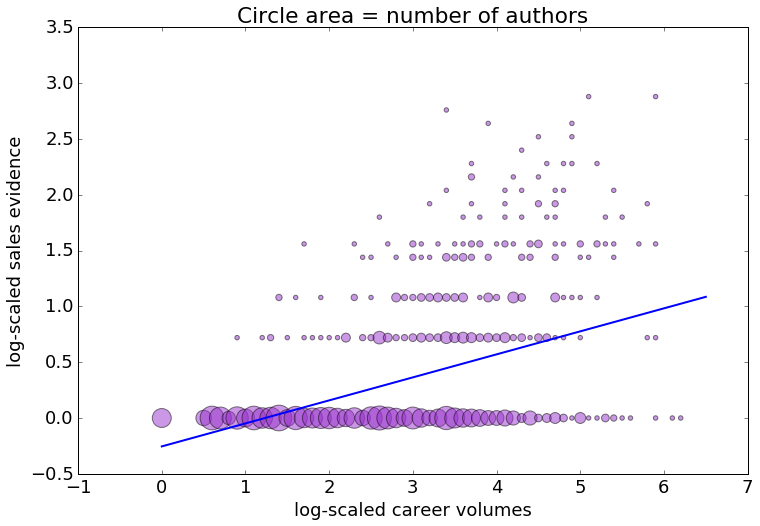

In [441]:
# Let's start by log-scaling both variables

authordata['logvols'] = np.log(authordata.num_vols + 1)
authordata['logsales'] = np.log(authordata.salesevidence + 1)

def get_binned_grid(authordata, yvariable):
    ''' This creates a dataframe that can be used to produce
    a scatterplot where circle size
    is proportional to the number of authors located in a
    particular "cell" of the grid.
    '''
    lv = []
    ls = []
    binsize = []
    for i in np.arange(0, 7, 0.1):
        for j in np.arange(0, 3.3, 0.12):
            thisbin = authordata[(authordata.logvols >= i - 0.05) & (authordata.logvols < i + 0.05) & (authordata[yvariable] >= j - 0.06) & (authordata[yvariable] < j + 0.06)]
            if len(thisbin) > 0:
                lv.append(i)
                ls.append(j)
                binsize.append(len(thisbin))

    dfdict = {'log-scaled career volumes': lv, 'log-scaled sales evidence': ls, 'binsize': binsize}
    df = pd.DataFrame(dfdict)
    return df

df = get_binned_grid(authordata, 'logsales')
lm = smf.ols(formula='logsales ~ logvols', data=authordata).fit()
xpred = np.linspace(0, 6.5, 50)
xpred = pd.DataFrame({'logvols': xpred})
ypred = lm.predict(xpred)

df.plot.scatter(x = 'log-scaled career volumes', y = 'log-scaled sales evidence', s = df.binsize * 20, color = 'darkorchid', 
                alpha = 0.5, figsize = (12,8), title = 'Circle area = number of authors')
plt.plot(xpred, ypred, linewidth = 2)
plt.show()

In [442]:
print('Pearson correlation & p value, unscaled: ', pearsonr(authordata.salesevidence, authordata.num_vols))
print('correlation & p value, logscaled: ', pearsonr(authordata.logsales, authordata.logvols))

Pearson correlation & p value, unscaled:  (0.40070865369609265, 4.4623999825890061e-42)
correlation & p value, logscaled:  (0.46700421358403166, 2.0190049011500869e-58)


I'm going to use log-scaling for visualization in the rest of the notebook, because it makes the correlation we're interested in more visible. But I will continue to manipulate the unscaled variables.

## Bayesian inferences

As you can see above, most of the weight of the graph is in that bottom row, where we have no direct evidence about the author's sales. That's because we're relying on "bestseller lists," which only report the very top of the market. But there is good reason to suspect that the loose correlation between volumes-preserved and sales would also extend down into the space above that bottom row, if we were using a source of evidence that didn't have such a huge gap between "zero appearances on a bestseller list" and "one appearance on a bestseller list."

More generally, there's good reason to suspect that a lot of our estimates of sales are too far from the blue regression line marked above. If you went out and gathered sales evidence from a different source, and asked me to predict where each author would fall in your sample, I would be well advised to *slide* my predictions toward that regression line, for reasons well explained in [a classic article by Bradley Efron and Carl Morris.](http://statweb.stanford.edu/~ckirby/brad/other/Article1977.pdf)

On the other hand, I wouldn't want to slide every prediction an equal distance. If I were smart, I would be particularly flexible about the authors where I have little evidence. We have a lot of evidence in the upper right-hand corner; we're not going to wake up tomorrow and discover that Charles Dickens was actually obscure. But toward the bottom of the graph, and the left-hand side, discovering a single new piece of evidence could dramatically change my estimate about an author who I thought was totally unknown.

Let's translate this casual reasoning into Bayesian language. We can use the loose correlation of sales and volumes-preserved to articulate a rough **prior probability** about the ratio likely to hold between those two variables.

Then we can improve our estimates of sales by viewing the bestseller lists as new evidence that merely *updates* our prior beliefs about authors, based on the shelf space they occupy in libraries. ([Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) is a formal way of explaining how we update our beliefs in the light of new evidence.)

But how much weight, exactly, should we give our prior? My first approach here was to say "um, I dunno, maybe fifty percent?" Which might be fine. But it turns out there's a more principled way to do this, which allows the weight of our prior to vary depending on the amount of new evidence we have for each writer. It's an approach called "empirical Bayes," because it infers a prior probability from patterns in the evidence. (Some people would argue that all Bayesian reasoning is empirical, but this notebook is not the place to hash that out!)

[As David Robinson has explained,](http://varianceexplained.org/r/empirical_bayes_baseball/) batting ratios can be imagined as a binomial distribution. Each time a batter goes up to the plate, they get a hit (1) or a miss (0), and the batting ratio is hits, divided by total at-bats. But if a batter has had very few visits to the plate, we're well advised to treat that ratio skeptically, sliding it toward our prior about the grand mean of batting averages for all hitters. It turns out that a good way to improve your estimate of a binomial distribution is to add a fixed amount to both sides of the ratio: the number of hits and the number of at-bats. If we're looking at someone who has had very few at-bats, those small fixed amounts can dramatically change their batting average, moving it toward the grand mean. Hank Aaron has had a lot of at-bats, so he's not going to slide around much. 

We could view appearances on bestseller lists *roughly* the same way. Each time an author publishes a book, they have a chance to appear on a bestseller list. So the bestseller count, divided by total volumes preserved, is *sort of roughly like* hits, divided by total at-bats. I'm repeating "roughly" in italics because, of course, we aren't literally counting each book that an author published and checking how many copies it sold. We're using very rough and incomplete proxies for both variables. So the binomial assumption is probably not *entirely* accurate. But it may be accurate enough to improve our very spotty evidence about sales.

Well, as Robinson [and Julia Silge have explained](http://juliasilge.com/blog/Bayesian-Blues/) better than I can, if you've got a bunch of binomial distributions, you can often improve your estimates by assuming that the parameters \theta of those distributions are drawn from a hyperparameter that has the shape of a Beta distribution, governed by parameters \alpha and \beta. (Alpha and beta then become the fixed amounts you add to your counts of "hits" and "at-bats.") The code below is going to try to find those parameters.

There is one tricky, ad-hoc thing I add to the mix, which actually does make a big difference. One of the big problems with my evidence is that there's a huge gap between **one** volume on a bestseller list and **no** volumes. In reality, I know that market prominence is not counted by integers, and there ought to be a lot more fuzziness, which will matter especially at the bottom of the scale. To reflect this assumption I add some normally-distributed noise to the sales estimates before modeling them with a Beta distribution.

Initial guess:  0.332820558812 4.10670220049
Improved guess:  0.566955882953 8.39052063877


/Users/tunder/miniconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


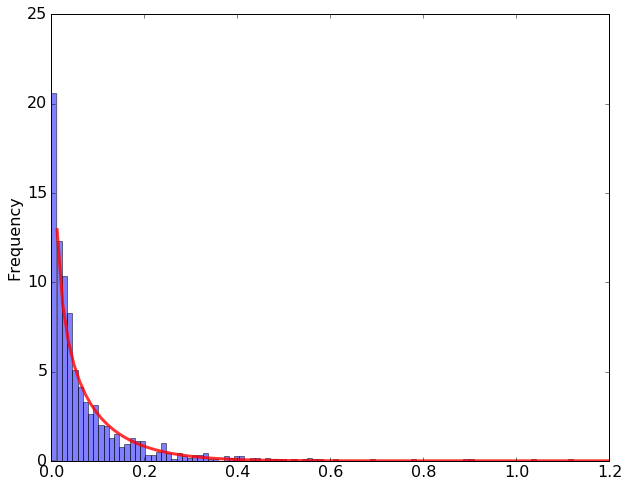

In [546]:
# Let's create some normally-distributed noise

# To make this replicable, set a specific seed
random.seed(1702)
# The birthday of Rev. Thomas Bayes.

randomnoise = np.array([np.random.normal(loc = 0, scale = 0.5) for x in range(len(authordata))])

for i in range(len(randomnoise)):
    if randomnoise[i] < 0 and authordata.salesevidence[i] < abs(randomnoise[i]):
        randomnoise[i] = abs(randomnoise[i])
authordata['noisyprior'] = authordata.salesevidence + randomnoise
authordata['ratio'] = authordata.noisyprior / (authordata.num_vols + 1)
fig, ax = plt.subplots(figsize = (10,8))
authordata['ratio'].plot.hist(bins = 100, alpha = 0.5, normed = True)

# The method of moments gives us an initial approximation for alpha and beta.
mu = np.mean(authordata.ratio)
sigma2 = np.var(authordata.ratio)
alpha0 = ((1 - mu) / sigma2 - 1 / mu) * (mu**2)
beta0 = alpha0 * (1 / mu - 1)
print("Initial guess: ", alpha0, beta0)

alpha0, beta0 , c, d = ss.beta.fit(authordata.ratio, alpha0, beta0)

x = np.linspace(0, 1.2, 100)
betamachine = ss.beta(alpha0, beta0)
plt.plot(x, betamachine.pdf(x), 'r-', lw=3, alpha=0.8, label='beta pdf')
print("Improved guess: ", alpha0, beta0)

#### The Beta distribution above

The histogram shows the number of occurrences of different **ratios** between salesevidence and num_vols (actually using a noisy prior instead of salesevidence itself).

The red line shows a Beta distribution fit to the histogram. Alpha is 0.0597, Beta is 8.807.

#### Applying the prior, and updating our posterior estimate

We inherit parameters alpha0 and beta0 from the cell above, and apply them to update salesevidence.

The logic of the updating is: first, use our prior about the distribution of sales *ratios* to slide the observed ratio for an author toward the prior. We do that by adding alpha0 to salesevidence and both alpha0 and beta0 to num_vols, then calculating a new ratio.

Finally, we use the recalculated ratio to adjust our original estimate of salesevidence by multiplying the new ratio times num_vols. **Note that I also log-scale the posterior.**

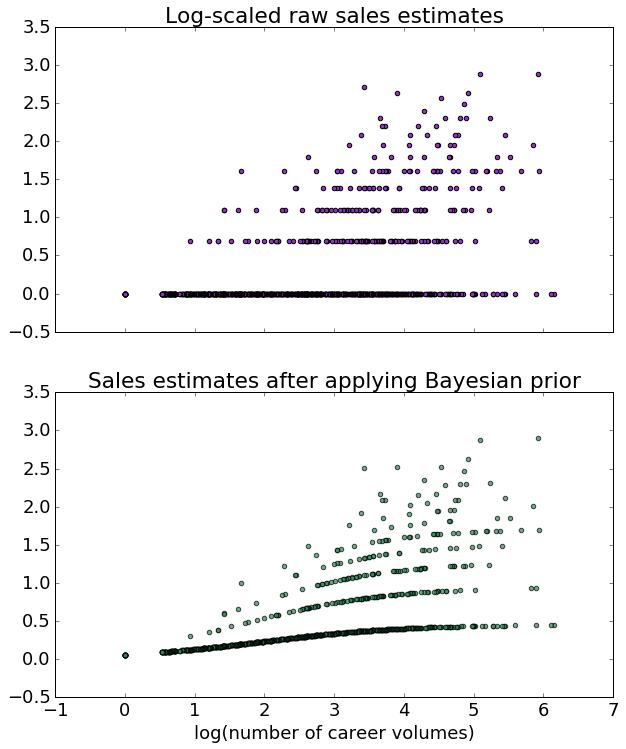

In [559]:
# Below we actually create a posterior estimate.

authordata['posterior'] = 0
for i in authordata.index:
    y = authordata.loc[i, 'salesevidence']
    x = authordata.loc[i, 'num_vols'] + 1
    authordata.loc[i, 'posterior'] = np.log((x * ((y + alpha0) / (x + alpha0 + beta0))) + 1)

# Now we visualize the change.    

# Two subplots, sharing the X axis
fig, axarr = plt.subplots(2, sharex = True, figsize = (10, 12))
matplotlib.rcParams.update({'font.size': 18})
axarr[0].scatter(authordata.logvols, authordata.logsales, c = 'darkorchid')
axarr[0].set_title('Log-scaled raw sales estimates')
axarr[1].scatter(authordata.logvols, authordata.posterior, c = 'seagreen', alpha = 0.7)
axarr[1].set_title('Sales estimates after applying Bayesian prior')
axarr[1].set_xlabel('log(number of career volumes)')
plt.show()


This is my favorite part of the notebook, because principled inferences turn out to be pretty.

You can see that the Bayesian prior has relatively little effect on the rankings of prominent authors in the upper right-hand corner (Charles Dickens and Ellen Wood are still going to be the two dots at the top). But it very substantially warps space at the bottom and on the left side of the graph, giving the lower image a bit more flair.

The other nice thing about this method is that it allows us to calculate uncertainty. I'm not going to do that in this notebook, but if we wanted to, we could calculate "credible intervals" for each author.

#### How this affects history

In this project, I'm less worried about individual authors than about the overall historical picture. How has that changed?

We can use our "midcareer" estimates for each author to plot them on a timeline.

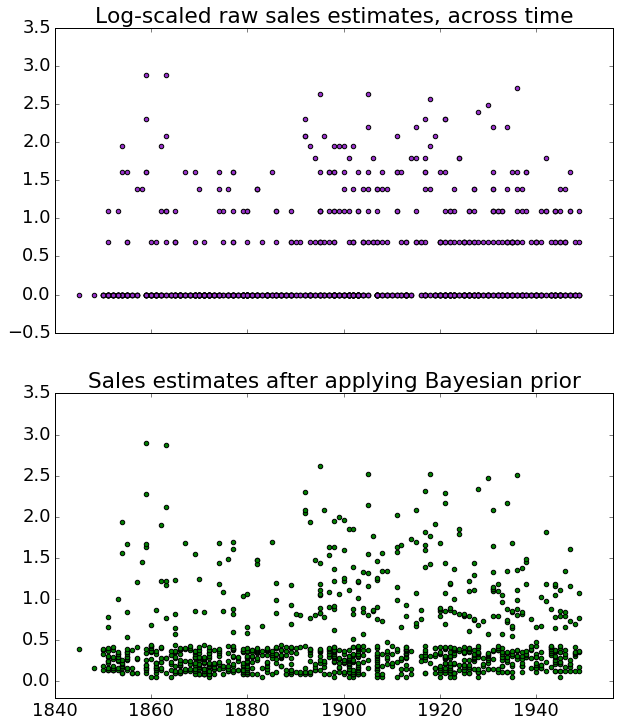

In [548]:
# Two subplots, sharing the X axis
fig, axarr = plt.subplots(2, sharex = True, figsize = (10, 12))
matplotlib.rcParams.update({'font.size': 18})
axarr[0].scatter(authordata.midcareer, authordata.logsales, c = 'darkorchid')
axarr[0].set_title('Log-scaled raw sales estimates, across time')
axarr[1].scatter(authordata.midcareer, authordata.posterior, c = 'green')
axarr[1].set_title('Sales estimates after applying Bayesian prior')
axarr[1].set_xlim((1840, 1956))
axarr[1].set_ylim((-0.2, 3.5))
plt.show()

You can still see that authors not mentioned in bestseller lists are grouped together at the bottom of the frame. But they are no longer separated from the rest of the data by a rigid gulf. We can make a slightly better guess about the differences between different people in that group.

The Bayesian prior also slightly tweaks our sense of the relative prominence of bestselling authors, by using the number of volumes preserved in libraries as an additional source of evidence. But, as you can see, it doesn't make big alterations at the top of the scale.

By the way, who's actually up there? Mostly familiar names. I'm not hung up on the exact sorting of the top ten or twenty names. If that was our goal, we could certainly do a better job by checking publishers' archives for the top ten or twenty people. Even existing studies by Altick, etc, could give us a better sorting at the top of the list. But remember, we've got more than a thousand authors in this corpus! The real goal of this project is to achieve a coarse macroscopic sorting of the "top," "middle," and "bottom" of that much larger list. So here are the top fifty, in no particular order.

In [549]:
authordata.sort_values(by = 'posterior', inplace = True, ascending = False)
thetop = np.array(authordata.index.tolist()[0:50])
thetop.shape = (25, 2)
thetop

array([['Dickens, Charles', 'Wood, Ellen'],
       ['Ward, Mary Augusta', 'Churchill, Winston'],
       ['Rinehart, Mary Roberts', '(Lloyd Cassel), Douglas, Lloyd C'],
       ['Lewis, Sinclair', 'Deeping, Warwick'],
       ['Tarkington, Booth', 'Barrie, J. M'],
       ['Grey, Zane', 'Reade, Charles'],
       ['Wright, Harold Bell', 'Bromfield, Louis'],
       ['McCutcheon, George Barr', 'Braddon, M. E'],
       ['Hilton, James', 'Burnett, Frances Hodgson'],
       ['Doyle, Arthur Conan', 'Stratton-Porter, Gene'],
       ['Caine, Hall', 'Bacheller, Irving'],
       ['Kipling, Rudyard', 'Parker, Gilbert'],
       ['Hope, Anthony', 'Kingsley, Charles'],
       ['Corelli, Marie', 'Porter, Eleanor H'],
       ['Southworth, Emma Dorothy Eliza Nevitte', 'Johnston, Mary'],
       ['Galsworthy, John', 'Tolstoy, Leo'],
       ['Steinbeck, John', 'Hichens, Robert'],
       ['Ferber, Edna', 'Glasgow, Ellen Anderson Gholson'],
       ['Dell, Ethel M', 'Sedgwick, Anne Douglas'],
       ['Stevenson, 

#### percentile calculations

The distribution of authors across prominence is not really uniform. But for some purposes of visualization it's nice to have a uniform distribution, so let's create one. We can think of it as the author's "percentile" location within a moving 50-year window.

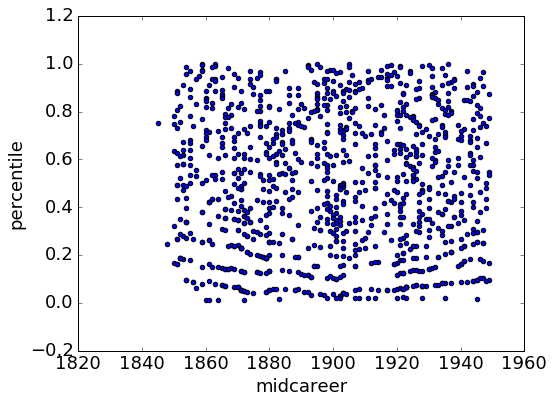

In [550]:
authordata['percentile'] = 0
for name in authordata.index:
    mid = authordata.loc[name, 'midcareer']
    subset = authordata.posterior[(authordata.midcareer > mid - 25) & ((authordata.midcareer < mid + 25))]
    ranking = sorted(list(subset))
    thisauth = authordata.loc[name, 'posterior']
    for idx, element in enumerate(ranking):
        if thisauth < element:
            break
    percent = idx / len(ranking)
    authordata.loc[name, 'percentile'] = percent
authordata.plot.scatter(x = 'midcareer', y = 'percentile', figsize = (8,6))
authordata.to_csv('authordata.csv')

## How sales interact with critical prestige

In a separate analytical project, I've contrasted two samples of fiction (one drawn from reviews in elite periodicals, the other selected at random) to develop a loose model of literary prestige, as seen by reviewers.

Underline *loose*. Evidence about prestige is even fuzzier and harder to come by than evidence about sales. So this model has to rely on a couple of random samples, combined with the language of the text itself. It is only 72.5% accurate at predicting which works of fiction come from the reviewed set -- so by all means, take its predictions with a grain of salt! However, even an imperfect model can reveal loose organizing principles, and that's what we're interested in here.

#### Loading evidence of prestige

The model we're loading was produced by modeling each of the four quarter-centuries separately: (1850-74, 75-99, 1900-24, 25-49). Then the results of all four models were concatenated. This is going to be important when we analyze changes over time; we know that volumes in the twentieth century, for instance, were not evaluated using nineteenth-century critical standards. (In practice, the standards we can model don't change very rapidly, but it's worth making these divisions just to be on the safe side.)

In [551]:
prestigery = dict()

with open('prestigedata.csv', encoding = 'utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        auth = row['author']
        if auth not in prestigery:
            prestigery[auth] = []
        prestigery[auth].append(float(row['logistic']))

authordata['prestige'] = float('nan')
for k, v in prestigery.items():
    if k in authordata.index:
        authordata.loc[k, 'prestige'] = sum(v) / len(v)

onlyboth = authordata.dropna(subset = ['prestige'])
onlyboth.shape

(927, 18)

#### Let's explore the literary field!

Using this data, we can quantitatively recreate Pierre Bourdieu's map of social space.

To get a sense of what we're looking at, it may be helpful first of all just to see where some familiar names fall.


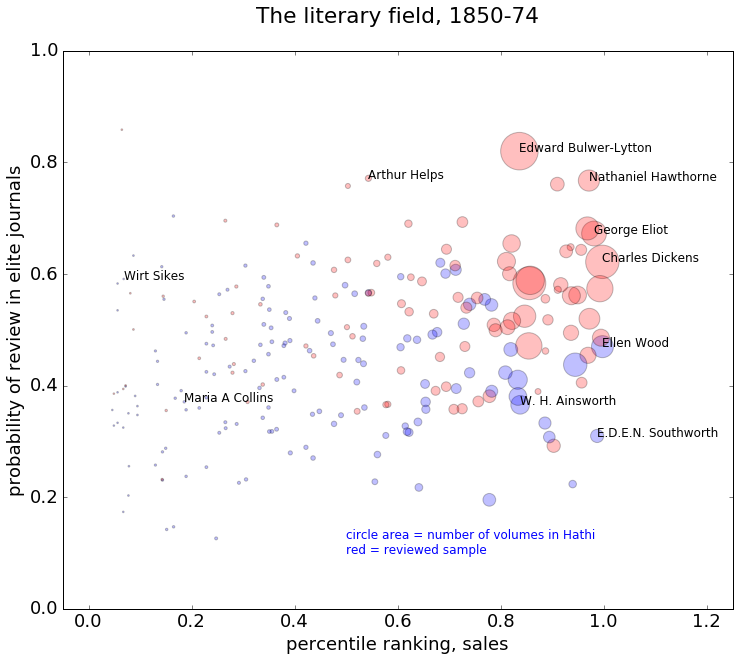

In [690]:
def get_a_period(aframe, floor, ceiling):
    ''' Extracts a chronological slice of our data.
    '''
    subset = aframe[(aframe.midcareer >= floor) & (aframe.midcareer < ceiling)]
    x = subset.percentile
    y = subset.prestige
    return x, y, subset

def get_an_author(anauthor, aframe):
    ''' Gets coordinates for an author in a given space.
    '''
    if anauthor not in aframe.index:
        return 0, 0
    else:
        x = aframe.loc[anauthor, 'percentile']
        y = aframe.loc[anauthor, 'prestige']
        return x, y

def plot_author(officialname, vizname, aperiod, ax):
    x, y = get_an_author(officialname, aperiod)
    ax.text(x, y, vizname, fontsize = 12)

def revtocolor(number):
    if number > 0.1:
        return 'red'
    else:
        return 'blue'
    
# Let's plot the mid-Victorians

xvals, yvals, victoriana = get_a_period(onlyboth, 1840, 1875)
victoriana = victoriana.assign(samplecolor = victoriana.reviews.apply(revtocolor))
ax = victoriana.plot.scatter(x = 'percentile', y = 'prestige', s = victoriana.num_vols * 3, alpha = 0.25,
                             c = victoriana.samplecolor, figsize = (12,10))

authors_to_plot = {'Dickens, Charles': 'Charles Dickens', "Wood, Ellen": 'Ellen Wood', 
                   'Ainsworth, William Harrison': 'W. H. Ainsworth', 
                   'Lytton, Edward Bulwer Lytton': 'Edward Bulwer-Lytton',
                  'Eliot, George': 'George Eliot', 'Sikes, Wirt': 'Wirt Sikes', 
                   'Collins, A. Maria': 'Maria A Collins',
                  'Hawthorne, Nathaniel': "Nathaniel Hawthorne",
                  'Southworth, Emma Dorothy Eliza Nevitte': 'E.D.E.N. Southworth',
                  'Helps, Arthur': 'Arthur Helps'}

for officialname, vizname in authors_to_plot.items():
    plot_author(officialname, vizname, victoriana, ax)

ax.set_xlabel('percentile ranking, sales')
ax.set_ylabel('probability of review in elite journals')
ax.set_title('The literary field, 1850-74\n')
ax.text(0.5, 0.1, 'circle area = number of volumes in Hathi\nred = reviewed sample', color = 'blue', fontsize = 12)
ax.set_ylim((0,1))
ax.set_xlim((-0.05,1.25))
plt.show()


The upward drift of these points reveals a fairly strong correlation between prestige and sales. It is possible to find a few high-selling authors who are predicted to lack critical prestige -- notably, for instance, the historical novelist W. H. Ainsworth and the sensation novelist Ellen Wood, author of *East Lynne*. It's harder to find authors who have prestige but no sales: there's not much in the northwest corner of the map. Arthur Helps, a Cambridge Apostle, is a fairly lonely figure.

Fast-forward fifty years and we see a different picture.

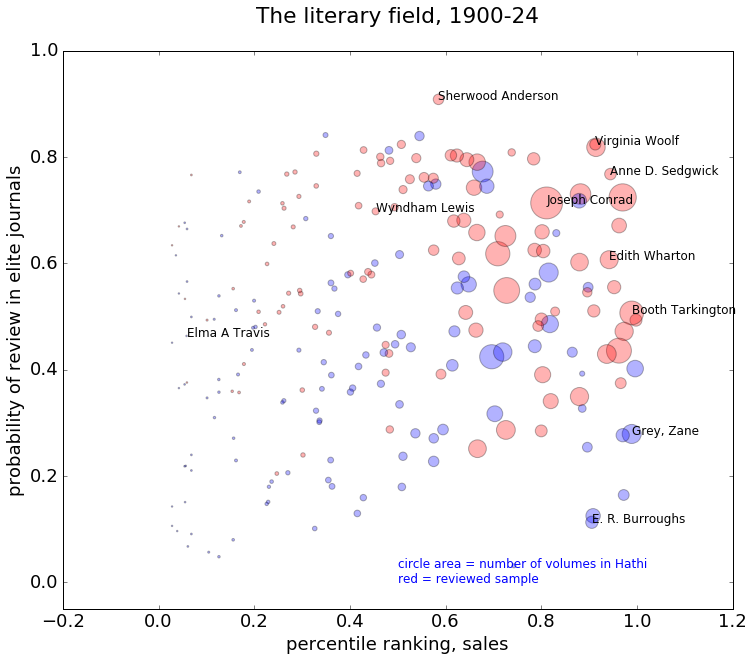

In [688]:
# Let's plot modernism!

xvals, yvals, modernity = get_a_period(onlyboth, 1900,1925)
modernity = modernity.assign(samplecolor = modernity.reviews.apply(revtocolor))
ax = modernity.plot.scatter(x = 'percentile', y = 'prestige', s = modernity.num_vols * 3, c = modernity.samplecolor, alpha = 0.3, figsize = (12,10))

authors_to_plot = {'Burroughs, Edgar Rice': 'E. R. Burroughs', 'Anderson, Sherwood': 'Sherwood Anderson', 
                  'Wharton, Edith': 'Edith Wharton', 'Conrad, Joseph': 'Joseph Conrad', 'Lewis, Wyndham': 'Wyndham Lewis',
                  'Grey, Zane': 'Grey, Zane', 'Travis, Elma A': 'Elma A Travis', 'Sedgwick, Anne Douglas': 'Anne D. Sedgwick',
                   'Woolf, Virginia': 'Virginia Woolf', 'Tarkington, Booth': 'Booth Tarkington'}

for officialname, vizname in authors_to_plot.items():
    plot_author(officialname, vizname, modernity, ax)

ax.set_xlabel('percentile ranking, sales')
ax.set_ylabel('probability of review in elite journals')
ax.set_title('The literary field, 1900-24\n')
ax.text(0.5, 0.0, 'circle area = number of volumes in Hathi\nred = reviewed sample', color = 'blue', fontsize = 12)
ax.set_ylim((-0.05,1))
plt.show()

Here, again, an upward drift reveals a loose correlation between prestige and sales. But is the correlation perhaps a bit weaker? There seem to be more authors in the "upper midwest" portion of the map now -- people like Wyndham Lewis and Sherwood Anderson, who have critical prestige but not enormous sales.

There's also a distinct "genre fiction" and "pulp fiction" world emerging in the southeast corner of this map. E. Phillips Oppenheim, British author of adventure fiction, would be right next to Edgar Rice Burroughs, if we had room to print both names.

Moreover, if you just look at the large circles (the authors we're likely to remember), you can start to see how people in this period might get the idea that sales are actually *negatively* correlated with critical prestige. It almost looks like a diagonal line slanting down from Sherwood Anderson to Zane Grey. If you look at the bigger picture, the slant is actually going the other direction. The people over by Elma Travis would sadly remind us that, in fact, prestige still correlates positively with sales! But you can see how that might not be obvious at the top of the market. There's a faint backward slant on the right-hand side that wasn't visible among the Victorians.

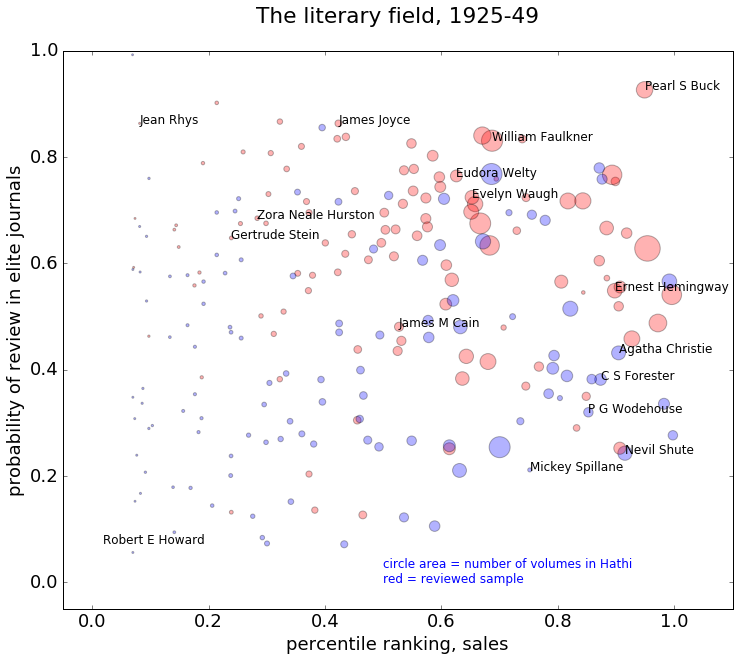

In [692]:
# Let's plot modernism!

xvals, yvals, modernity2 = get_a_period(onlyboth, 1925,1950) 
modernity2 = modernity2.assign(samplecolor = modernity2.reviews.apply(revtocolor))
ax = modernity2.plot.scatter(x = 'percentile', y = 'prestige', s = modernity2.num_vols * 3, 
                             c = modernity2.samplecolor, alpha = 0.3, figsize = (12,10))

authors_to_plot = {'Cain, James M': 'James M Cain', 'Faulkner, William': 'William Faulkner',
                   'Stein, Gertrude': 'Gertrude Stein', 'Hemingway, Ernest': 'Ernest Hemingway',
                  'Joyce, James': 'James Joyce', 'Forester, C. S. (Cecil Scott)': 'C S Forester',
                  'Spillane, Mickey': 'Mickey Spillane', 'Welty, Eudora': 'Eudora Welty', 
                   'Howard, Robert E': 'Robert E Howard', 'Buck, Pearl S': 'Pearl S Buck',
                  'Shute, Nevil': 'Nevil Shute', 'Waugh, Evelyn': 'Evelyn Waugh', 
                   'Christie, Agatha': 'Agatha Christie', 'Rhys, Jean': 'Jean Rhys',
                   'Wodehouse, P. G': 'P G Wodehouse',
                   'Hurston, Zora Neale': 'Zora Neale Hurston'}

for officialname, vizname in authors_to_plot.items():
    plot_author(officialname, vizname, modernity2, ax)

ax.set_xlabel('percentile ranking, sales')
ax.set_ylabel('probability of review in elite journals')
ax.set_title('The literary field, 1925-49\n')
ax.text(0.5, 0.0, 'circle area = number of volumes in Hathi\nred = reviewed sample', color = 'blue', fontsize = 12)
ax.set_ylim((-0.05,1))
ax.set_xlim((-0.05, 1.1))
plt.show()

In the second quarter of the twentieth century, the slope of the upper right quadrant becomes even more visible. The whole field is now, in effect, round. Scroll back up to the Victorians, and you'll see that wasn't true.

#### The overall correlation between sales and prestige

But we don't have to rely on vague visual guesses to estimate the strength of the correlation between two variables. Let's measure the correlation, and ask how it varies over time.


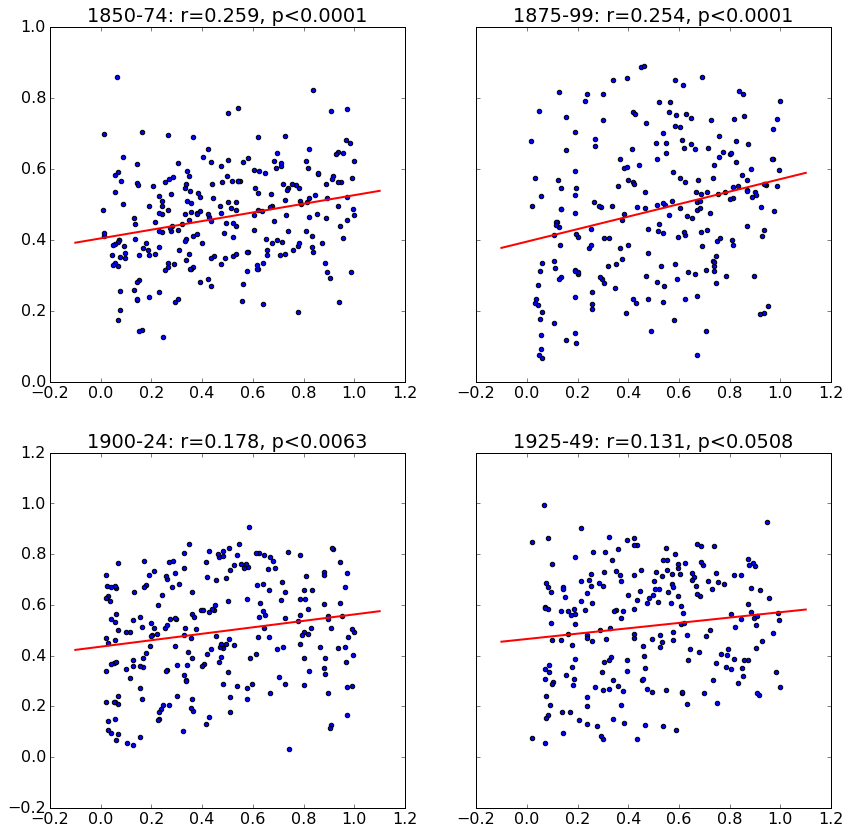

In [695]:
pears = []
pvals = []
for floor in range(1850, 1950, 25):
    ceiling = floor + 25
    pear = pearsonr(onlyboth.percentile[(onlyboth.midcareer >= floor) & (onlyboth.midcareer < ceiling)], onlyboth.prestige[(onlyboth.midcareer >= floor) & (onlyboth.midcareer < ceiling)])
    pears.append(int(pear[0]*1000)/1000)
    pvals.append(int((pear[1]+ .0001)*10000)/10000)

def get_line(subset):
    lm = smf.ols(formula='prestige ~ percentile', data=subset).fit()
    xpred = np.linspace(-0.1, 1.1, 50)
    xpred = pd.DataFrame({'percentile': xpred})
    ypred = lm.predict(xpred)
    return xpred, ypred

matplotlib.rcParams.update({'font.size': 16})
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='row', sharey='row', figsize = (14, 14))
x, y, subset = get_a_period(onlyboth, 1840, 1875)
ax1.scatter(x, y)
xpred, ypred = get_line(subset)
ax1.plot(xpred, ypred, linewidth = 2, color = 'red')
ax1.set_title('1850-74: r=' + str(pears[0]) + ", p<" + str(pvals[0]))

x, y, subset = get_a_period(onlyboth, 1875, 1900)
ax2.scatter(x, y)
xpred, ypred = get_line(subset)
ax2.plot(xpred, ypred, linewidth = 2, color = 'red')
ax2.set_title('1875-99: r=' + str(pears[1])+ ", p<" + str(pvals[1]))
quartercenturies.append(subset)

x, y, subset = get_a_period(onlyboth, 1900, 1925)
ax3.scatter(x, y)
xpred, ypred = get_line(subset)
ax3.plot(xpred, ypred, linewidth = 2, color = 'red')
ax3.set_title('1900-24: r=' + str(pears[2])+ ", p<" + str(pvals[2]))
quartercenturies.append(subset)

x, y, subset = get_a_period(onlyboth, 1925, 1960)
ax4.scatter(x, y)
xpred, ypred = get_line(subset)
ax4.plot(xpred, ypred, linewidth = 2, color = 'red')
ax4.set_title('1925-49: r=' + str(pears[3])+ ", p<" + str(pvals[3]))
quartercenturies.append(subset)

### So what have we achieved?

There is a steady decline in the correlation between prestige and sales. The correlation coefficient (*r*) steadily declines -- and for whatever it's worth, the p value is less than 0.05 in the first three plots, but not significant in the last. It's not a huge change, but that itself may be part of what we learn using this method.

I think this decline is roughly what we might expect to see: popularity and prestige are *supposed* to stop correlating as we enter the twentieth century. But I'm still extremely happy to see the pattern emerge. 

For one thing, we may be getting some new insights about the way well-known transformations at the top of the market relate to the less-publicized struggles of Wirt Sikes and Elma A Travis. Our received literary histories sometimes make it sound like modernism introduces a yawning chasm in the literary field — [Andreas Huyssen's "Great Divide."](http://www.iupress.indiana.edu/product_info.php?products_id=21292) If you focus on the upper right-hand corner of the map, that description may be valid. But if you back out for a broader picture, this starts to look like a rather subtle shift — perhaps just a *rounding out* of the literary field as new niches are filled in.

More fundamentally, I'm pleased to see that the method itself works. The evidence we're working with is rough and patchy; we had to make a lot of dubious inferences along the road. But the inferences seem to work: we're getting a map of the literary field that looks loosely familiar, and that changes over time roughly as we might expect it to change. This looks like a foundation we could build on: we could start to pose questions, for instance, about the way publishing houses positioned themselves in this space.

### A simpler solution

However, if you're not impressed by the clouds of dots above, the truth is that we don't need my textual model of literary prestige to confirm the divergence of sales and prestige across this century. At the top of the market, the changes are quite dramatic. So a straightforward Pearson correlation between sales evidence and the number of reviews an author gets from elite publications will do the trick.

Note that I make no pretense of having counted *all* reviews; this is just the number of times I (and the research assistants mentioned in "Acknowledgements" above) encountered an author in our random sample of elite journals. And since it's hard to sample entirely randomly, it is possible that the number of reviews is shaped (half-consciously) by our contemporary assumptions about prestige, encouraging us to "make sure we get so-and-so." I think, however, the declining correlation is too dramatic to be explained away in that fashion.

In [696]:
for floor in range(1850, 1950, 25):
    ceiling = floor + 25
    x, y, aperiod = get_a_period(authordata, floor, ceiling)
    pear = pearsonr(aperiod.posterior, aperiod.reviews)
    print(floor, ceiling, pear)

1850 1875 (0.41961505018103024, 1.6396552274157274e-12)
1875 1900 (0.23758651675814632, 0.0001403905915471629)
1900 1925 (0.13964622132073368, 0.019843099595737285)
1925 1950 (0.04537597732113291, 0.46115019352610997)


You don't even have to use my posterior estimate of sales. The raw counts will work, though the correlation is not as strong.

In [697]:
for floor in range(1850, 1950, 25):
    ceiling = floor + 25
    x, y, aperiod = get_a_period(authordata, floor, ceiling)
    pear = pearsonr(aperiod.salesevidence, aperiod.reviews)
    print(floor, ceiling, pear)

1850 1875 (0.28147075353153889, 4.0216860612257107e-06)
1875 1900 (0.1813380033588359, 0.0038730047927785036)
1900 1925 (0.081468805215053036, 0.17558055499319189)
1925 1950 (-0.031597897277567087, 0.6079182677833368)


Let's save the data so other notebooks can use it.

In [694]:
authordata.to_csv('data/authordata.csv', index_label = 'author')
onlyboth.to_csv('data/pairedwithprestige.csv', index_label = 'author')